# IndraQuantum: Architecture Analysis & Comparison

This notebook analyzes the performance and characteristics of the **IndraQuantum** model compared to a standard baseline.
It also explores the **Quantum Graph** structure where text is modeled as a hierarchy of quantum systems (Tokens -> Sentences -> Paragraphs).

## 1. Initialization Analysis
We compare the "Quantum Polar Initialization" (Magnitude ~ 1, Random Phase) vs Standard Gaussian Initialization.


Analyzing Initialization...


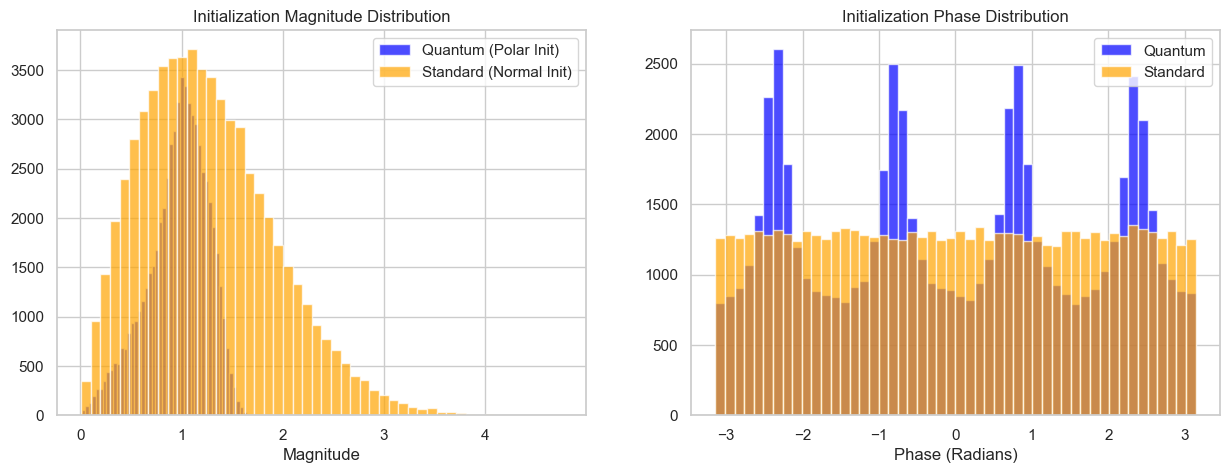

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from indra.models.embedding import QuantumEmbedding

def analyze_initialization(vocab_size=1000, d_model=64):
    print("Analyzing Initialization...")
    
    # Quantum Embedding
    q_emb = QuantumEmbedding(vocab_size, d_model)
    q_weights = q_emb.embedding.weight.detach()
    real, imag = torch.chunk(q_weights, 2, dim=-1)
    q_mags = torch.sqrt(real**2 + imag**2).flatten().numpy()
    q_phases = torch.atan2(imag, real).flatten().numpy()
    
    # Standard Embedding
    s_emb = nn.Embedding(vocab_size, d_model * 2)
    s_weights = s_emb.weight.detach()
    s_real, s_imag = torch.chunk(s_weights, 2, dim=-1)
    s_mags = torch.sqrt(s_real**2 + s_imag**2).flatten().numpy()
    s_phases = torch.atan2(s_imag, s_real).flatten().numpy()
    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    axs[0].hist(q_mags, bins=50, alpha=0.7, label='Quantum (Polar Init)', color='blue')
    axs[0].hist(s_mags, bins=50, alpha=0.7, label='Standard (Normal Init)', color='orange')
    axs[0].set_title("Initialization Magnitude Distribution")
    axs[0].set_xlabel("Magnitude")
    axs[0].legend()
    
    axs[1].hist(q_phases, bins=50, alpha=0.7, label='Quantum', color='blue')
    axs[1].hist(s_phases, bins=50, alpha=0.7, label='Standard', color='orange')
    axs[1].set_title("Initialization Phase Distribution")
    axs[1].set_xlabel("Phase (Radians)")
    axs[1].legend()
    
    plt.show()

analyze_initialization()


## 2. Training Performance Comparison
We compare the training loss curves of:
1. **IndraQuantum**: Complex-valued MLP with Quantum Embeddings.
2. **Standard Baseline**: Real-valued MLP with same parameter count.
3. **IndraQuantum Graph**: Graph-based model with Token-Sentence-Paragraph hierarchy.

*Note: Models are trained using Knowledge Distillation from a TinyLlama teacher.*


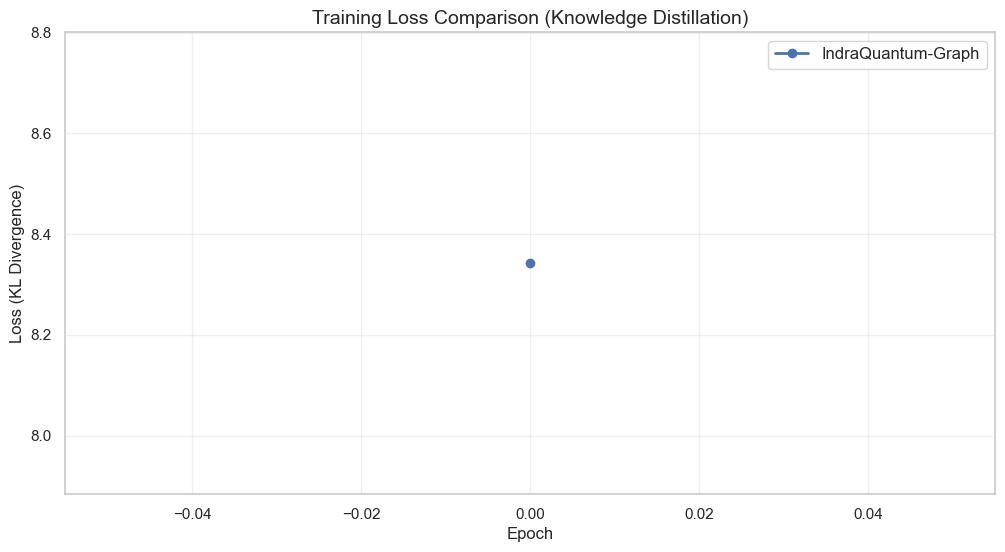

In [7]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style
sns.set_theme(style="whitegrid")

def plot_training_comparison():
    log_dir = "../logs"
    data = {}
    
    # Load Data
    files = {
        'IndraQuantum': 'history_quantum.pkl',
        'Baseline': 'history_baseline.pkl',
        'IndraQuantum-Graph': 'history_graph.pkl'
    }
    
    for name, filename in files.items():
        path = os.path.join(log_dir, filename)
        if os.path.exists(path):
            with open(path, "rb") as f:
                history = pickle.load(f)
                # Handle different formats if any (some might be dict, some list)
                if isinstance(history, dict):
                    data[name] = history['loss']
                else:
                    data[name] = history
        else:
            print(f"Warning: {filename} not found in {log_dir}")

    if not data:
        print("No training data found. Please run the training scripts first.")
        return

    # Plot
    plt.figure(figsize=(12, 6))
    for name, losses in data.items():
        plt.plot(losses, label=name, marker='o', linewidth=2)
        
    plt.title("Training Loss Comparison (Knowledge Distillation)", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss (KL Divergence)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Save plot to plots folder as well
    if not os.path.exists("../plots"):
        os.makedirs("../plots")
    plt.savefig("../plots/notebook_comparison_plot.png")
    plt.show()

plot_training_comparison()


## 3. Performance Benchmark
We dynamically calculate the **Parameters**, **Inference Latency**, and **Peak Memory Usage** for the models.
This ensures we are looking at real metrics on the current hardware, rather than hardcoded estimates.


Benchmarking Standard Baseline...
Benchmarking Indra Quantum...
Benchmarking Indra Graph...

Performance Metrics:
               Model  Parameters  Latency (ms)  Memory (MB)
0  Standard Baseline    17075456     14.209640            0
1      Indra Quantum    16681216     13.788414            0
2        Indra Graph    18134064     23.322427            0


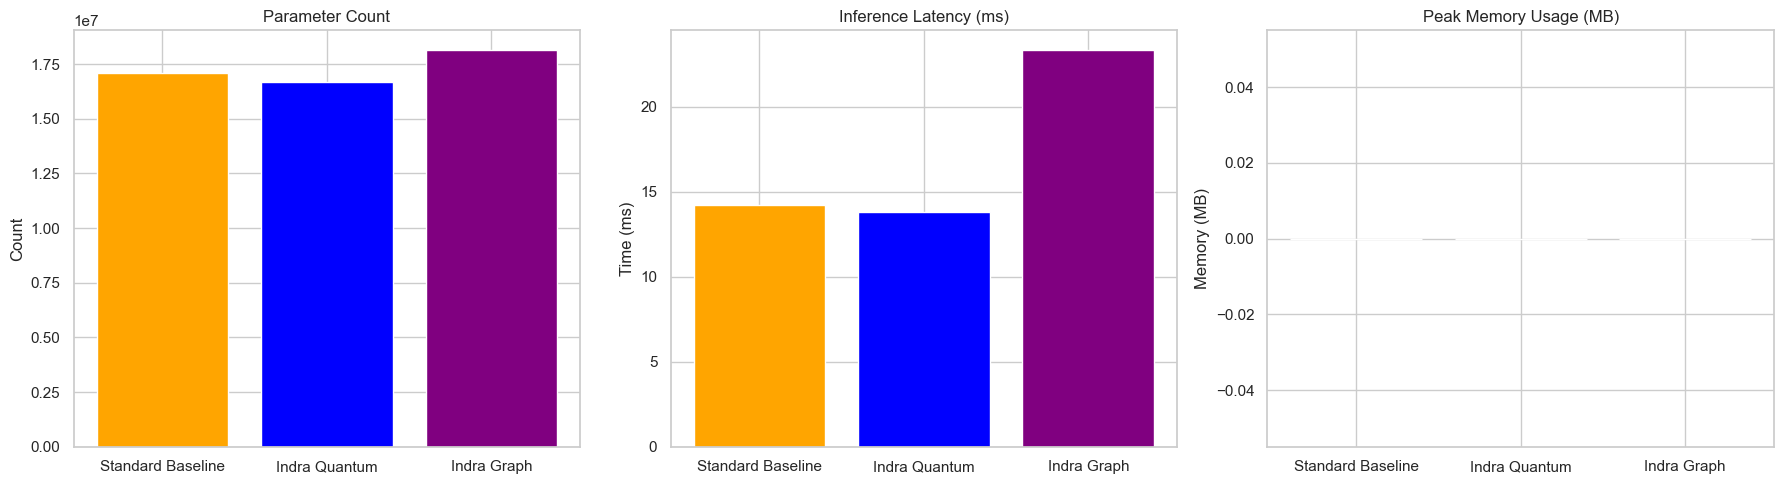

In [8]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
from indra.models.quantum_core import IndraQuantum
from indra.models.baseline import StandardBaseline
from indra.models.quantum_graph import IndraQuantumGraph

def measure_metrics(model_name, model, input_shape, device='cuda'):
    print(f"Benchmarking {model_name}...")
    # Parameters
    params = sum(p.numel() for p in model.parameters())
    
    # Move to device
    try:
        model = model.to(device)
    except RuntimeError as e:
        print(f"Failed to move {model_name} to {device}: {e}")
        return None
        
    model.eval()
    
    input_ids = torch.randint(0, 1000, input_shape).to(device)
    
    # Handle Graph Model Inputs
    if isinstance(model, IndraQuantumGraph):
        node_types = torch.zeros(input_shape, dtype=torch.long).to(device)
        # Dummy graph mask: [B, S, S] - Identity for minimal overhead test
        graph_mask = torch.eye(input_shape[1]).unsqueeze(0).expand(input_shape[0], -1, -1).to(device)
        inputs = (input_ids, node_types, graph_mask)
    else:
        inputs = (input_ids,)
        
    # Warmup
    try:
        with torch.no_grad():
            for _ in range(5):
                model(*inputs)
    except Exception as e:
        print(f"Warmup failed for {model_name}: {e}")
        return None

    # Latency
    torch.cuda.synchronize() if device == 'cuda' else None
    start = time.time()
    with torch.no_grad():
        for _ in range(20): # 20 runs for speed
            model(*inputs)
    torch.cuda.synchronize() if device == 'cuda' else None
    end = time.time()
    latency = (end - start) / 20 * 1000 # ms
    
    # Memory (Peak Allocated)
    if device == 'cuda':
        torch.cuda.reset_peak_memory_stats()
        with torch.no_grad():
            model(*inputs)
        memory = torch.cuda.max_memory_allocated() / 1024 / 1024 # MB
    else:
        memory = 0 # Cannot easily measure CPU memory this way
    
    return {
        "Model": model_name,
        "Parameters": params,
        "Latency (ms)": latency,
        "Memory (MB)": memory
    }

# Config
vocab_size = 32000
d_model = 128
seq_len = 128 
batch_size = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate Models
models = [
    ("Standard Baseline", StandardBaseline(vocab_size, d_model)),
    ("Indra Quantum", IndraQuantum(vocab_size, d_model)),
    ("Indra Graph", IndraQuantumGraph(vocab_size, d_model))
]

results = []
for name, model in models:
    res = measure_metrics(name, model, (batch_size, seq_len), device)
    if res:
        results.append(res)

# Create DataFrame
if results:
    df = pd.DataFrame(results)
    print("\nPerformance Metrics:")
    print(df)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Params
    axes[0].bar(df["Model"], df["Parameters"], color=['orange', 'blue', 'purple'])
    axes[0].set_title("Parameter Count")
    axes[0].set_ylabel("Count")

    # Latency
    axes[1].bar(df["Model"], df["Latency (ms)"], color=['orange', 'blue', 'purple'])
    axes[1].set_title("Inference Latency (ms)")
    axes[1].set_ylabel("Time (ms)")

    # Memory
    axes[2].bar(df["Model"], df["Memory (MB)"], color=['orange', 'blue', 'purple'])
    axes[2].set_title("Peak Memory Usage (MB)")
    axes[2].set_ylabel("Memory (MB)")

    plt.tight_layout()
    if not os.path.exists("../plots"):
        os.makedirs("../plots")
    plt.savefig("../plots/benchmark_metrics.png")
    plt.show()
else:
    print("No results to plot.")


## 4. Graph Model Analysis
We analyze the **Learned Edge Biases** of the trained `IndraQuantumGraph` model.
The model has a learnable bias for different edge types:
1. **Local Bias**: Attention to nearby tokens (sliding window).
2. **Hierarchy Bias**: Attention along structural edges (Token <-> Sentence <-> Paragraph).

If the **Hierarchy Bias** is non-zero (and distinct from zero), it confirms the model is **actively using the graph structure** during processing.


Analyzing Graph Model Weights...
Model loaded successfully.

Learned Bias Weights (Layer 0):
     Head  Local Bias  Hierarchy Bias
0  Head 1    0.001310       -0.001343
1  Head 2   -0.002159       -0.000070
2  Head 3    0.001472       -0.000609
3  Head 4    0.001798        0.002425


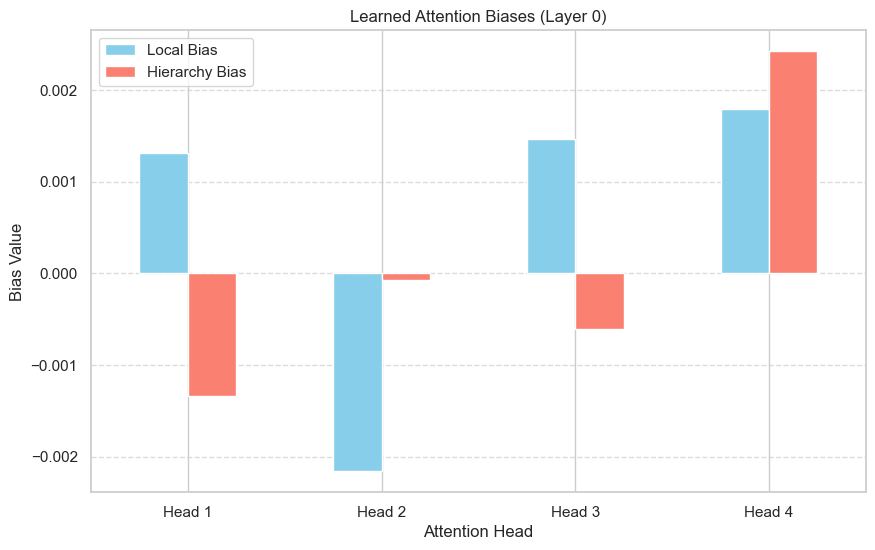

In [9]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

# Add project root
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from indra.models.quantum_graph import IndraQuantumGraph

def analyze_graph_weights():
    print("Analyzing Graph Model Weights...")
    
    checkpoint_path = "../checkpoints/quantum_graph.pt"
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found at {checkpoint_path}. Run scripts/train_graph.py first.")
        return

    # Initialize Model (Same config as training)
    vocab_size = 32002 # 32000 + 2 special tokens
    d_model = 128
    model = IndraQuantumGraph(vocab_size, d_model)
    
    # Load Weights
    try:
        state_dict = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(state_dict)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Extract Bias Weights from the first layer
    # Shape: [n_heads, 3] -> (Local, Hierarchy, Global)
    layer_idx = 0
    bias_weights = model.layers[layer_idx].bias_weights.detach().numpy()
    n_heads = bias_weights.shape[0]
    
    # Create DataFrame
    data = []
    for h in range(n_heads):
        data.append({
            "Head": f"Head {h+1}",
            "Local Bias": bias_weights[h, 0],
            "Hierarchy Bias": bias_weights[h, 1]
        })
    
    df = pd.DataFrame(data)
    print("\nLearned Bias Weights (Layer 0):")
    print(df)
    
    # Plot
    df.plot(x="Head", y=["Local Bias", "Hierarchy Bias"], kind="bar", figsize=(10, 6), color=['skyblue', 'salmon'])
    plt.title(f"Learned Attention Biases (Layer {layer_idx})")
    plt.ylabel("Bias Value")
    plt.xlabel("Attention Head")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    
    if not os.path.exists("../plots"):
        os.makedirs("../plots")
    plt.savefig("../plots/graph_bias_analysis.png")
    plt.show()

analyze_graph_weights()


## 5. Quantum Graph Structure
Visualizing the adjacency matrix of the text graph.
- **Nodes**: Tokens (0), Sentences (1), Paragraphs (2)
- **Edges**: Hierarchical connections (Token <-> Sentence <-> Paragraph)


Sequence Length: 32
Node Types: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 2 1 1]


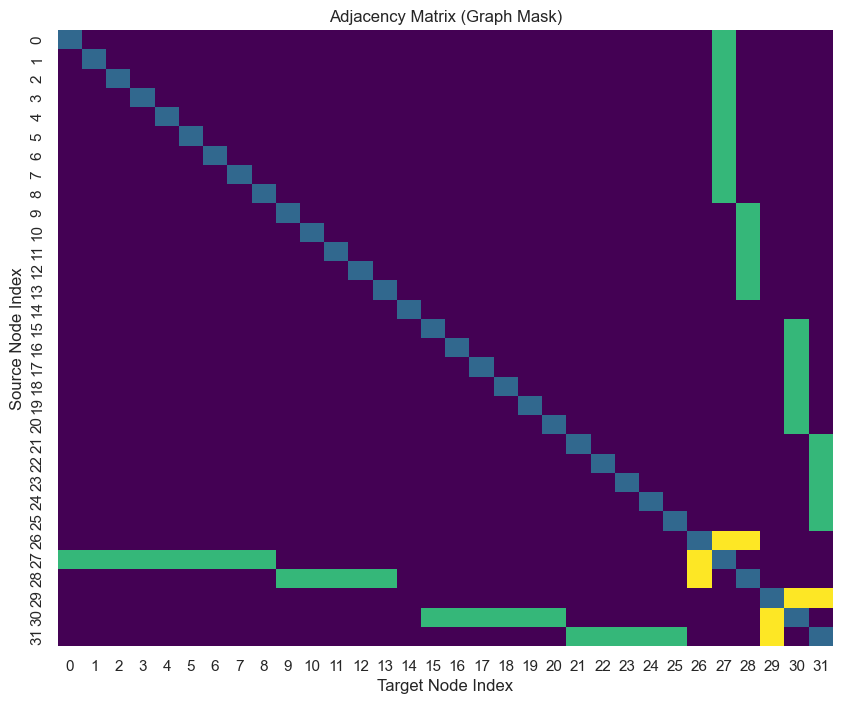

In [10]:
from indra.graph.builder import TextGraphBuilder
from transformers import AutoTokenizer
import seaborn as sns

def visualize_graph_structure():
    # Load Tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
    except:
        print("Could not load TinyLlama tokenizer, using dummy.")
        return

    builder = TextGraphBuilder(tokenizer)
    text = "Quantum mechanics is fascinating. It explains the universe.\nThis is a new paragraph. It adds more context."
    
    graph = builder.build_graph(text)
    adj = graph['graph_mask'].numpy()
    node_types = graph['node_types'].numpy()
    
    print(f"Sequence Length: {len(node_types)}")
    print(f"Node Types: {node_types}")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(adj, cmap="viridis", cbar=False)
    plt.title("Adjacency Matrix (Graph Mask)")
    plt.xlabel("Target Node Index")
    plt.ylabel("Source Node Index")
    plt.show()

visualize_graph_structure()
